# Export lion patches to training dataset

In [1]:
INPUT_DIR='../../input/kaggle-sea-lion/'
OUTPUT_DIR='../../output/kaggle-sea-lion/02/'

DEBUG = False
FORCE_IMAGES = None
#more than 7 errors
#[66, 186, 187, 235, 292, 342, 418, 426, 516, 529, 585, 593, 643, 803, 816, 857, 871, 912, 920]
#more than 4 errors
#[15, 38, 62, 66, 67, 105, 122, 129, 186, 187, 207, 235, 240, 252, 265, 291, 292, 306, 342, 412, 418, 426, 437, 516, 526, 529, 585, 587, 593, 598, 604, 629, 643, 751, 761, 776, 803, 816, 837, 847, 857, 871, 886, 899, 912, 920, 941]
#more than 2 errors
#[15, 32, 36, 38, 62, 66, 67, 77, 93, 96, 105, 112, 122, 127, 129, 178, 186, 187, 189, 197, 207, 235, 240, 252, 265, 291, 292, 297, 299, 306, 330, 342, 359, 362, 383, 386, 394, 395, 398, 403, 405, 409, 412, 418, 426, 434, 437, 438, 452, 465, 473, 476, 495, 509, 510, 516, 526, 529, 551, 571, 574, 585, 587, 593, 595, 598, 604, 606, 629, 643, 679, 700, 704, 724, 739, 750, 751, 759, 761, 773, 776, 785, 803, 816, 822, 823, 827, 837, 847, 857, 871, 872, 886, 889, 899, 900, 906, 910, 912, 917, 920, 924, 925, 941]
SKIP_IMAGES = [66, 186, 187, 235, 292, 342, 418, 426, 516, 529, 585, 593, 643, 803, 816, 857, 871, 912, 920]

IMAGE_DIMS = (84,84,3)
LABEL_DIMS = (6,)

#%prun print('test')
#%pdb

In [2]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os

import modules.logging
from modules.logging import logger
import modules.lions as lions
from modules.utils import Timer
import modules.utils as utils

Using TensorFlow backend.


## Prepare output dataset

In [3]:
utils.mkdirs(OUTPUT_DIR, recreate=True)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
logger.info('Dir ' + OUTPUT_DIR + ' created')

x_ds = None
y_ds = None

logger.info('creating dataset')
dataset_path = OUTPUT_DIR + utils.dataset_name('lion-patches', IMAGE_DIMS)
h5file = h5py.File(dataset_path, 'w')
x_ds, y_ds = utils.create_xy_dataset(h5file, IMAGE_DIMS, LABEL_DIMS, x_dtype='u1')
logger.info('done')

2017-05-04 02:25:33,014 INFO Dir ../../output/kaggle-sea-lion/02/ created
2017-05-04 02:25:33,017 INFO creating dataset
2017-05-04 02:25:33,022 INFO done


## Process input photos and extract lions patches to dataset

### Open csv files

In [4]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]
MISMATCHED = MISMATCHED + SKIP_IMAGES
logger.info('loading train.csv')
train = pd.read_csv(INPUT_DIR + "Train/train.csv")

2017-05-04 02:25:33,036 INFO loading train.csv


### Process each photo

In [5]:
logger.info('process all photos from train file')
count = 0
total_errors = np.zeros(LABEL_DIMS[0]-1)
total_classes = np.zeros(LABEL_DIMS[0])
total_classes_added = np.zeros(LABEL_DIMS[0])
total_too_many_errors = []
for row in train.itertuples():
    #load images
    train_id = row[1]
    
    if(FORCE_IMAGES!=None and train_id not in FORCE_IMAGES):
        continue
    
    image_raw_file = INPUT_DIR + 'Train/'+ str(train_id) +'.jpg'
    image_dotted_file = INPUT_DIR + 'TrainDotted/'+ str(train_id) +'.jpg'

    if(train_id in MISMATCHED):
        logger.warning('skipping mismatched train_id ' + str(train_id))
        continue
    
    if(not os.path.isfile(image_raw_file)):
        logger.warning('file not found. skipping. file=' + image_raw_file)
        continue

    t = Timer('processing photo ' + image_raw_file)
    image_raw = cv2.imread(image_raw_file)
    image_dotted = cv2.imread(image_dotted_file)
    
    classes_count_total, classes_count_added = lions.export_lions(image_raw, image_dotted, x_ds, y_ds, IMAGE_DIMS, debug=DEBUG, min_distance_others=0, non_lion_distance=120)
    
    logger.info('detected classes count')
    logger.info(str(classes_count_total))
    logger.info('-----')
    logger.info('expected classes count')
    logger.info(str(row))
    logger.info('-----')
    logger.info('errors per class')
    error = np.subtract(row[2:], classes_count_total[0:5])
    nr_errors = abs(np.sum(error))
    if(nr_errors>7):
        total_too_many_errors.append(train_id)
        logger.warning(str(nr_errors) + ' ERRORS ON TRAIN ID ' + str(train_id))
    logger.info(str(error))
    logger.info('acum errors per class')
    total_errors = np.add(total_errors, np.absolute(error)[0:5])
    logger.info(str(total_errors))
    logger.info('-----')
    logger.info('acum detected classes count total')
    total_classes = np.add(total_classes, classes_count_total)
    logger.info(str(total_classes))
    logger.info('-----')
    logger.info('acum detected classes count added to dataset')
    total_classes_added = np.add(total_classes_added, classes_count_added)
    logger.info(str(total_classes_added))
    t.stop()
    
    count = count + 1

logger.info('ERRORS PER CLASS')
logger.info(str(total_errors))

logger.info('TRAIN_IDS WITH TOO MANY ERRORS')
logger.info(str(total_too_many_errors))

h5file.close()

2017-05-04 02:25:33,091 INFO process all photos from train file
2017-05-04 02:25:33,098 WARNING file not found. skipping. file=../../input/kaggle-sea-lion/Train/0.jpg
2017-05-04 02:25:33,100 WARNING file not found. skipping. file=../../input/kaggle-sea-lion/Train/1.jpg
2017-05-04 02:25:33,102 WARNING file not found. skipping. file=../../input/kaggle-sea-lion/Train/2.jpg
2017-05-04 02:25:33,103 WARNING skipping mismatched train_id 3
2017-05-04 02:25:33,105 WARNING file not found. skipping. file=../../input/kaggle-sea-lion/Train/4.jpg
2017-05-04 02:25:33,107 WARNING file not found. skipping. file=../../input/kaggle-sea-lion/Train/5.jpg
2017-05-04 02:25:33,109 WARNING file not found. skipping. file=../../input/kaggle-sea-lion/Train/6.jpg
2017-05-04 02:25:33,110 WARNING skipping mismatched train_id 7
2017-05-04 02:25:33,111 WARNING file not found. skipping. file=../../input/kaggle-sea-lion/Train/8.jpg
2017-05-04 02:25:33,113 WARNING skipping mismatched train_id 9
2017-05-04 02:25:33,116 WA

### Validate dataset

2017-05-05 08:30:04,657 INFO showing 100 images
2017-05-05 08:30:04,667 INFO > [started] generating image patches. rows=11; cols=10...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/utils.py:613: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(image_labels!=None):


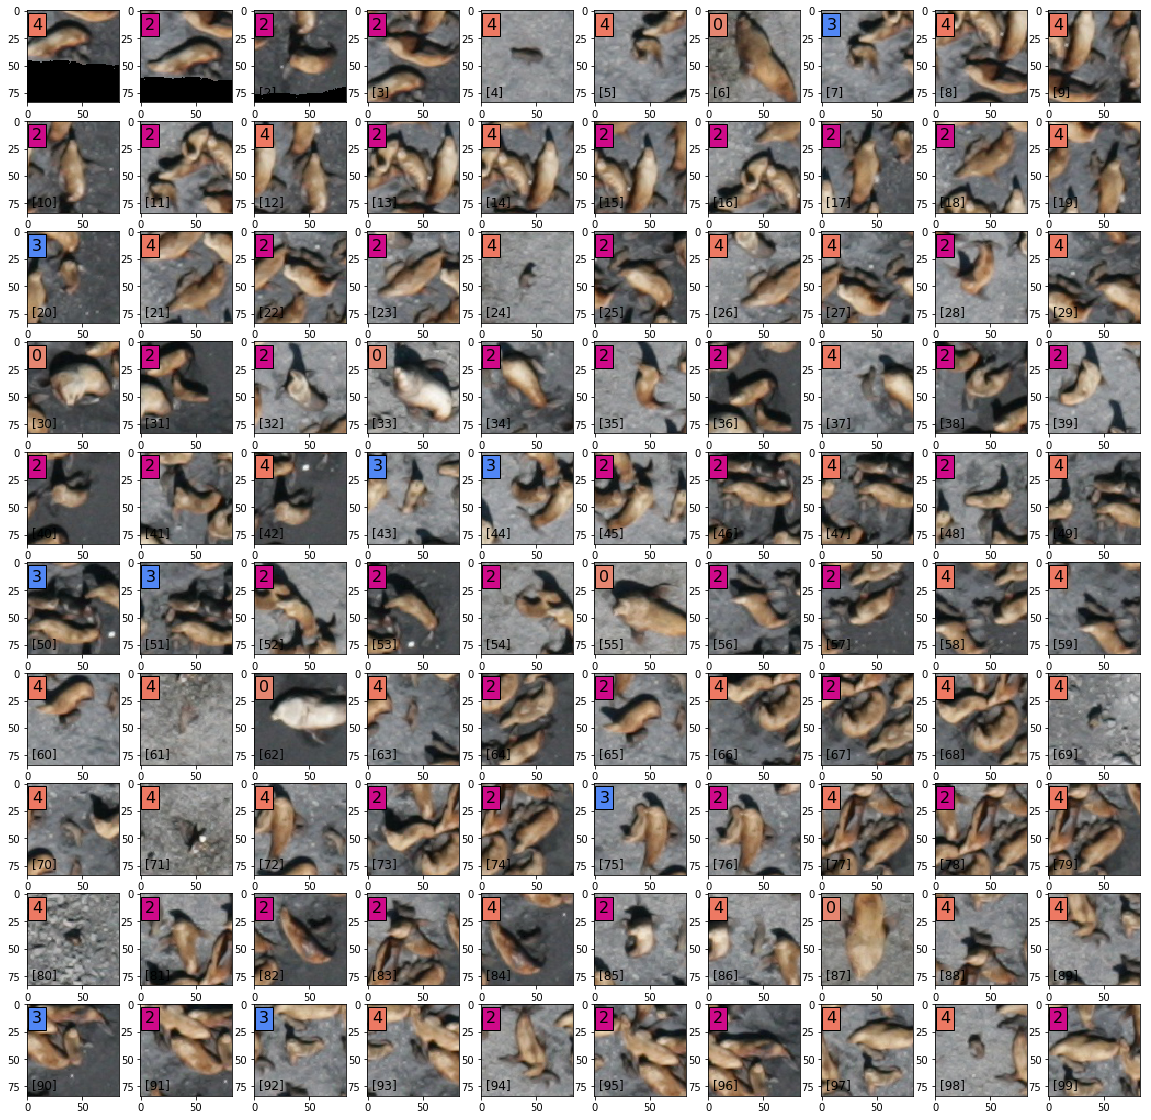

2017-05-05 08:30:14,267 INFO > [done]    generating image patches. rows=11; cols=10 (9599.740 ms)
2017-05-05 08:30:14,319 INFO output dataset length 2263
2017-05-05 08:30:14,321 INFO class distribution
2017-05-05 08:30:14,324 INFO [  78   45  675  150  281 1034]


In [7]:
dataset_path = OUTPUT_DIR + utils.dataset_name('lion-patches', IMAGE_DIMS)
with h5py.File(dataset_path, 'r') as h5file:
    utils.show_images(h5file['X'][0:100].astype('uint8'), image_labels=utils.onehot_to_label(h5file['Y'][0:100]), is_bgr=True, cols=10, size=2)
    logger.info('output dataset length ' + str(len(h5file['Y'][()])))
    logger.info('class distribution')
    logger.info(str(utils.class_distribution(h5file['Y'][()])))

In [ ]:
utils.print_progress(10, 21, elapsed_seconds=32, size=25)

In [ ]:
'|############48%-------------| 10/21 32s'